In [1]:
import numpy as np
import pandas as pd

import os
import glob
import librosa
import tqdm
import pickle
import time

from collections import Counter, defaultdict

from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim import lr_scheduler
from torch import nn
import torch.nn.functional as F
import torch

from skmultilearn.model_selection import iterative_train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import utils
from flame import Trainer

sns.set()

DATA_PATH = './data'
join_path = lambda path: os.path.join(DATA_PATH, path)

In [2]:
with open(join_path('train_mels.pkl'), 'rb+') as f:
    train_X = pickle.load(f)
    
with open(join_path('val_mels.pkl'), 'rb+') as f:
    val_X = pickle.load(f)
    
train_y = np.load(join_path('train_targets.npy'))
val_y = np.load(join_path('val_targets.npy'))

In [3]:
train_ds = utils.create_ds(train_X, train_y)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

val_ds = utils.create_ds(val_X, val_y)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)

In [6]:
# Learning Sound Event Classifiers from Web Audio with Noisy Labels
# https://arxiv.org/abs/1901.01189

class ModifiedDCNN(nn.Module):
    def __init__(self, hid=256):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=24, kernel_size=5),
            nn.MaxPool2d(kernel_size=(4, 2), stride=(4, 2)),
            nn.BatchNorm2d(24),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=24, out_channels=48, kernel_size=5),
            nn.MaxPool2d(kernel_size=(4, 2), stride=(4, 2)),
            nn.BatchNorm2d(48),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=48, out_channels=48,kernel_size=5),
            nn.BatchNorm2d(48),
            nn.LeakyReLU()
        )
        
        self.clf = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=2400, out_features=hid),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=hid, out_features=80)
        )
        
        
    def forward(self, x):
        x = self.convs(x)
        x = x.flatten(start_dim=1)
        x = self.clf(x)
        return x

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCEWithLogitsLoss()

model = ModifiedDCNN(hid=256)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
logdir = join_path('ModifiedDCNN_logdir')

trainer = Trainer(model, optimizer, criterion, device, logdir)

scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode='max',
    factor=0.5,
    patience=10,
    verbose=True
)

In [8]:
losses, best_loss, epoch_time = utils.train_model(trainer, train_dl, val_dl, val_y, scheduler,
                                            n_epochs=1000, gap=20, verbose=True)

Epoch, best_val_lwlrap
   1, 0.1598
   2, 0.2079
   3, 0.2965
   4, 0.3526
   5, 0.3934
   6, 0.4301
   7, 0.4572
   8, 0.4720
   9, 0.5134
  10, 0.5209
  11, 0.5241
  12, 0.5284
  13, 0.5558
  14, 0.5824
  15, 0.5883
  16, 0.6216
  18, 0.6323
  20, 0.6495
  24, 0.6589
  29, 0.6684
  31, 0.6808
  40, 0.6952
  42, 0.6973
Epoch    53: reducing learning rate of group 0 to 5.0000e-04.
  54, 0.6981
  55, 0.6988
  57, 0.6991
  67, 0.7028
Epoch    78: reducing learning rate of group 0 to 2.5000e-04.
Done.


In [9]:
epoch_time, best_loss

(1.0241158584068561, 0.7027517104548191)

Text(0.5, 1.0, 'Logloss')

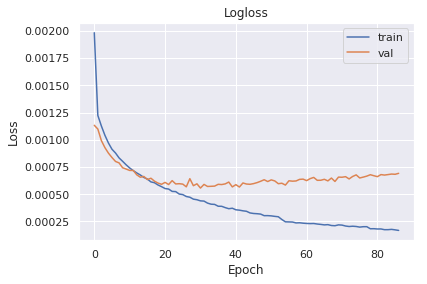

In [10]:
plt.plot(losses['train']['logloss'])
plt.plot(losses['val']['logloss'])
plt.legend(['train', 'val'])

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Logloss')

Text(0.5, 1.0, 'Lwlrap')

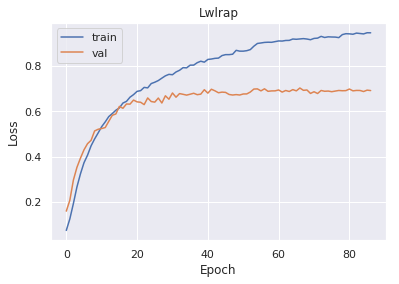

In [11]:
plt.plot(losses['train']['lwlrap'])
plt.plot(losses['val']['lwlrap'])
plt.legend(['train', 'val'])

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Lwlrap')

In [12]:
with open(join_path('ModifiedDCNN_losses.pkl'), 'wb+') as f:
    pickle.dump(losses, f)